# Projeto final para a disciplina de Processamento de Linguagem Natural

##Giovana Piorino Vieira de Carvalho - 2022035989



#Análise de tópicos dos comentários coletados


In [1]:
pip install fsspec==2024.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.2.0 which is incompatible.


In [2]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.3 MB/s eta 0:00:00


In [3]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 17.5 MB/s eta 0:00:00


In [4]:
%load_ext autoreload
%autoreload 2

# Bibliotecas padrão
import collections
import itertools
import json
import pickle as pkl
import random
import re

from transformers import AutoTokenizer, AutoModel

# Modelagem e análise de dados e tópicos
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
import numpy as np
import pandas as pd
import scipy
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from hdbscan import HDBSCAN
import networkx as nx
from multiprocessing import Pool
from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Outras bibliotecas
import unidecode

# Processamento de linguagem natural
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from spacy.lang.pt import Portuguese
import spacy

# Importando bibliotecas necessárias
import pandas as pd
import pickle as pkl
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from bertopic import BERTopic

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df = pd.read_csv("CommentsReddit.csv")

In [6]:
df

,Unnamed: 0,id,Comentário,class_result
0,0,htfz11y,Outra sugestão: procure o perfil no Instagram ...,2
1,1,hub93yq,Campeonato de quarto,1
2,2,hv1xsjp,Não entendi,1
3,3,hvsbpyg,"Mano, o Lucas Lima não esperou nem 10 minutos ...",0
4,4,hwzr3zr,Eu acho que ouvi um 🐄muuul,2
...,...,...,...,...
166,166,iwyyax0,1 O que fizeram em Los Angeles foi outra cois...,0
167,167,iyvd0es,"A última que eu tomei foi no meio desse ano, e...",2
168,168,izqc5yj,Lógico que desabou kkkkk,1
169,169,j0kxoll,como é bom ter democracia,2


In [7]:
#remocao de urls etc com regex

df.Comentário = list(
    map(
        lambda x: re.sub(
            r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)",
            "",
            x,
        ),
        df.Comentário.values,
    )
)

df.Comentário = list(
    map(
        lambda x: re.sub(
            r"(\n)|(\t)|(\s{2,})",
            " ",
            x,
        ),
        df.Comentário.values,
    )
)

In [7]:
#adicionando palavras indesejaveis nos topicos

stop_list = ['kkkkk','kkkkkkk','kkkkkk','kkkk','kkkkkkkk','kkkkkkkkk','kkk','kkkkkkkkkk']
stop_words=stopwords.words('portuguese')
stop_words.extend(stop_list)

In [8]:
from sentence_transformers import SentenceTransformer

# Removendo duplicatas e mantendo a primeira ocorrência
docs = list(df['Comentário'])

# Gerando os embeddings com o modelo pré-treinado
embedding_model_name = "rufimelo/Legal-BERTimbau-sts-base-ma-v2"
sentence_model = SentenceTransformer(embedding_model_name)
embeddings = sentence_model.encode(docs, show_progress_bar=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/898 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/678k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Invalid model-index. Not loading eval results into CardData.


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Invalid model-index. Not loading eval results into CardData.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
# Parâmetros configuráveis

embedding_model_name = "rufimelo/Legal-BERTimbau-sts-base-ma-v2"
n_neighbors_umap = 2
n_components_umap = 5
min_dist_umap = 0.00
metric_umap = 'cosine'
random_state_umap = 2023
min_cluster_size_hdbscan = 10
min_samples_hdbscan = 3
metric_hdbscan = 'euclidean'
max_features_vectorizer = 1000
min_df_vectorizer = 0.1
max_df_vectorizer = 0.99
min_topic_size_bertopic = 5
#top_n_words_bertopic = 80


# Configurando o modelo
sentence_model = SentenceTransformer(embedding_model_name)
umap_model = UMAP(n_neighbors=n_neighbors_umap, n_components=n_components_umap, min_dist=min_dist_umap,
                  metric=metric_umap, random_state=random_state_umap)
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size_hdbscan, min_samples=min_samples_hdbscan,
                        metric=metric_hdbscan, prediction_data=True)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
vectorizer_model = CountVectorizer(max_features=max_features_vectorizer, #tokenizer=tokenizer,
                                    min_df=min_df_vectorizer, max_df=max_df_vectorizer,
                                    stop_words=stop_words)
representation_model = MaximalMarginalRelevance(diversity=0.7)

# BERTopic
model1 = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model,
                 representation_model=representation_model, embedding_model=sentence_model,
                 min_topic_size=min_topic_size_bertopic, ctfidf_model=ctfidf_model,
                 verbose=True, vectorizer_model=vectorizer_model, calculate_probabilities=True)
topics, probabilities = model1.fit_transform(docs, embeddings)

#Analisando os top 20 tópicos
model1.get_topic_info()

Invalid model-index. Not loading eval results into CardData.
Invalid model-index. Not loading eval results into CardData.
2025-01-19 22:13:09,807 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-19 22:13:19,988 - BERTopic - Dimensionality - Completed ✓
2025-01-19 22:13:19,991 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-19 22:13:20,007 - BERTopic - Cluster - Completed ✓
2025-01-19 22:13:20,013 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-19 22:13:20,502 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,21,-1_internet_entendi_intermediadora_dinheiro,"[internet, entendi, intermediadora, dinheiro, ...",[Lidar com pedreiros é tipo abrir a caixa de P...
1,0,28,0_banho_zero_inspiração_amigo,"[banho, zero, inspiração, amigo, linha, casa, ...","[Nova Zelandia tá com -1,5% amigo, Brasil é -2..."
2,1,20,1_000_vida_igreja_cuidar,"[000, vida, igreja, cuidar, palavras, brincand...",[>Deixa as pessoas fazerem o que quiserem e la...
3,2,19,2_filme_gosto_nostalgica_milho,"[filme, gosto, nostalgica, milho, impacto, kkk...",[Esse é filme pra levar o filho pra assistir. ...
4,3,15,3_termina_times_italia_ranking,"[termina, times, italia, ranking, fodeu, confe...",[Errado. De 2002 pra sulamericano tem históric...
5,4,15,4_sentar_juntos_beber_futuro,"[sentar, juntos, beber, futuro, mínimo, colega...","[Político é engraçado demais, se alguém faz um..."
6,5,14,5_glorificado_mouse_mente_lembrei,"[glorificado, mouse, mente, lembrei, hebreus, ...",[Pra mim pizza doce não existe. É só um pão do...
7,6,13,6_nazista_narrativa_miragem_metade,"[nazista, narrativa, miragem, metade, machines...",[No meio desses 2.7 anos John chutou uma pedra...
8,7,13,7_professor_louco_namorado_link,"[professor, louco, namorado, link, inbox, garo...","[Já fui bonzinho, so me fudi, e hoje só quero ..."
9,8,13,8_dispensação_drogas_países_descriminalizaram,"[dispensação, drogas, países, descriminalizara...","[O patrimônio do Barsi não é público, ele é in..."


In [10]:
new_topics = model1.reduce_outliers(docs, topics , strategy="c-tf-idf", threshold=0.1)

In [11]:
model_updated = model1
model_updated.update_topics(docs, topics=new_topics, vectorizer_model=vectorizer_model)
model_updated.get_topic_info()

2025-01-19 22:13:20,758 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,19,-1_caso_mesma_porém_ainda,"[caso, mesma, porém, ainda, fi, prazo, lidar, ...",[Lidar com pedreiros é tipo abrir a caixa de P...
1,0,29,0_pra_tá_vai_banho,"[pra, tá, vai, banho, tomar, zero, cara, fala,...","[Nova Zelandia tá com -1,5% amigo, Brasil é -2..."
2,1,20,1_vida_vai_000_etc,"[vida, vai, 000, etc, bem, aí, população, igre...",[>Deixa as pessoas fazerem o que quiserem e la...
3,2,19,2_filme_sebos_gosto_metal,"[filme, sebos, gosto, metal, normalmente, para...",[Esse é filme pra levar o filho pra assistir. ...
4,3,16,3_post_coisa_gente_clubes,"[post, coisa, gente, clubes, copa, sulamerican...",[Errado. De 2002 pra sulamericano tem históric...
5,4,15,4_vai_trabalho_ter_briga,"[vai, trabalho, ter, briga, sentar, forte, fic...","[Político é engraçado demais, se alguém faz um..."
6,5,14,5_pão_doce_diabo_pqp,"[pão, doce, diabo, pqp, glorificado, mouse, me...",[Pra mim pizza doce não existe. É só um pão do...
7,6,13,6_tankie_nazista_defende_0km,"[tankie, nazista, defende, 0km, nano, narrativ...",[No meio desses 2.7 anos John chutou uma pedra...
8,7,13,7_professor_gostaria_hoje_coisas,"[professor, gostaria, hoje, coisas, vc, namora...","[Já fui bonzinho, so me fudi, e hoje só quero ..."
9,8,13,8_pra_legal_contra_drogas,"[pra, legal, contra, drogas, los, dispensação,...","[O patrimônio do Barsi não é público, ele é in..."


In [12]:
#new_topics = model_updated.reduce_topics(docs, nr_topics=50)
topics_updated = model_updated.topics_
#model_updated.update_topics(docs, topics=topics_updated, vectorizer_model=vectorizer_model)

In [13]:
model_updated.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,19,-1_caso_mesma_porém_ainda,"[caso, mesma, porém, ainda, fi, prazo, lidar, ...",[Lidar com pedreiros é tipo abrir a caixa de P...
1,0,29,0_pra_tá_vai_banho,"[pra, tá, vai, banho, tomar, zero, cara, fala,...","[Nova Zelandia tá com -1,5% amigo, Brasil é -2..."
2,1,20,1_vida_vai_000_etc,"[vida, vai, 000, etc, bem, aí, população, igre...",[>Deixa as pessoas fazerem o que quiserem e la...
3,2,19,2_filme_sebos_gosto_metal,"[filme, sebos, gosto, metal, normalmente, para...",[Esse é filme pra levar o filho pra assistir. ...
4,3,16,3_post_coisa_gente_clubes,"[post, coisa, gente, clubes, copa, sulamerican...",[Errado. De 2002 pra sulamericano tem históric...
5,4,15,4_vai_trabalho_ter_briga,"[vai, trabalho, ter, briga, sentar, forte, fic...","[Político é engraçado demais, se alguém faz um..."
6,5,14,5_pão_doce_diabo_pqp,"[pão, doce, diabo, pqp, glorificado, mouse, me...",[Pra mim pizza doce não existe. É só um pão do...
7,6,13,6_tankie_nazista_defende_0km,"[tankie, nazista, defende, 0km, nano, narrativ...",[No meio desses 2.7 anos John chutou uma pedra...
8,7,13,7_professor_gostaria_hoje_coisas,"[professor, gostaria, hoje, coisas, vc, namora...","[Já fui bonzinho, so me fudi, e hoje só quero ..."
9,8,13,8_pra_legal_contra_drogas,"[pra, legal, contra, drogas, los, dispensação,...","[O patrimônio do Barsi não é público, ele é in..."


In [14]:
model_updated.visualize_barchart(top_n_topics=8)

In [15]:
model_updated.get_topic(0, full=True)

{'Main': [('pra', 0.06745546595599733),
  ('tá', 0.06104513364590191),
  ('vai', 0.057997829260639136),
  ('banho', 0.04924306146136084),
  ('tomar', 0.04590596689894318),
  ('zero', 0.04590596689894318),
  ('cara', 0.04454014691738247),
  ('fala', 0.04333082771806791),
  ('fica', 0.04333082771806791),
  ('assim', 0.03795901515407075)]}

In [16]:
model_updated.get_topic(1, full=True)

{'Main': [('vida', 0.05454020745117495),
  ('vai', 0.05072812889876839),
  ('000', 0.042828707409849655),
  ('etc', 0.03847321498082571),
  ('bem', 0.035414471438508614),
  ('aí', 0.035414471438508614),
  ('população', 0.0344565774412828),
  ('igreja', 0.0344565774412828),
  ('cuidar', 0.0344565774412828),
  ('sempre', 0.03417182136872526)]}

In [17]:
model_updated.get_topic(2, full=True)

{'Main': [('filme', 0.10510703874945929),
  ('sebos', 0.07679904215705781),
  ('gosto', 0.07679904215705781),
  ('metal', 0.07679904215705781),
  ('normalmente', 0.07679904215705781),
  ('parada', 0.07679904215705781),
  ('perfil', 0.07007135916630619),
  ('ano', 0.05617406523763398),
  ('outros', 0.05617406523763398),
  ('vida', 0.047534442508467)]}

In [18]:
model_updated.get_topic(3, full=True)

{'Main': [('post', 0.07308121009554615),
  ('coisa', 0.055640545968285784),
  ('gente', 0.051216944749715644),
  ('clubes', 0.04983162394894683),
  ('copa', 0.04983162394894683),
  ('sulamericanos', 0.04983162394894683),
  ('parte', 0.04645464379414967),
  ('segunda', 0.04645464379414967),
  ('fez', 0.04384872605732769),
  ('melhor', 0.03841270856228673)]}

In [19]:
model_updated.get_topic(4, full=True)

{'Main': [('vai', 0.0736572431610117),
  ('trabalho', 0.06982888519019867),
  ('ter', 0.05008649471290204),
  ('briga', 0.05003095044474262),
  ('sentar', 0.04664046236932627),
  ('forte', 0.04664046236932627),
  ('ficar', 0.044024120961557),
  ('pessoa', 0.041897331114119196),
  ('pra', 0.04112085204677597),
  ('tá', 0.037213113470541806)]}

In [20]:
model_updated.get_topic(5, full=True)

{'Main': [('pão', 0.22209743985393463),
  ('doce', 0.1305583716669983),
  ('diabo', 0.1305583716669983),
  ('pqp', 0.11912131058272052),
  ('glorificado', 0.07510707674325402),
  ('mouse', 0.07510707674325402),
  ('mente', 0.07510707674325402),
  ('lembrei', 0.07510707674325402),
  ('jesus', 0.07510707674325402),
  ('hebreus', 0.07510707674325402)]}

In [21]:
model_updated.get_topic(6, full=True)

{'Main': [('tankie', 0.1269317502318039),
  ('nazista', 0.1269317502318039),
  ('defende', 0.1269317502318039),
  ('0km', 0.0730207690559414),
  ('nano', 0.0730207690559414),
  ('narrativa', 0.0730207690559414),
  ('miragem', 0.0730207690559414),
  ('metade', 0.0730207690559414),
  ('machines', 0.0730207690559414),
  ('marçal', 0.0730207690559414)]}

In [22]:
model_updated.get_topic(7, full=True)

{'Main': [('professor', 0.11423857520862352),
  ('gostaria', 0.11423857520862352),
  ('hoje', 0.09171691866991043),
  ('coisas', 0.09171691866991043),
  ('vc', 0.07501799537662575),
  ('namorado', 0.06571869215034727),
  ('louco', 0.06571869215034727),
  ('link', 0.06571869215034727),
  ('jogo', 0.06571869215034727),
  ('zap', 0.06571869215034727)]}

In [23]:
df['topics'] = topics_updated

In [24]:
pd.set_option('display.max_colwidth', None)

df['topics']

,topics
0,2
1,0
2,-1
3,0
4,-1
...,...
166,8
167,2
168,6
169,0


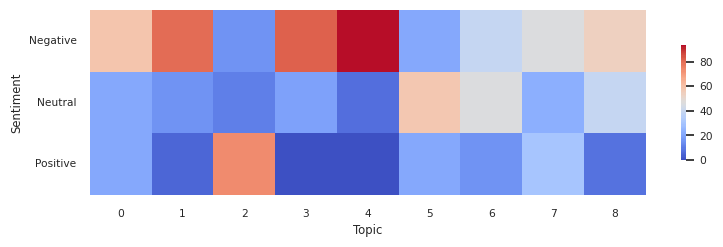

In [25]:
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt

# Remover as ocorrências onde topics é igual a -1.0
df1 = df[df['topics'] != -1.0]

# Ajuste para o agrupamento
grouped2 = df1.groupby(['topics', 'class_result']).size().unstack(fill_value=0)
grouped2.index = grouped2.index.astype(int)

# Calculando a porcentagem para o heatmap
freq_porcentagem2 = grouped2.div(grouped2.sum(axis=1), axis=0) * 100

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
sns.set(font_scale=0.7)

cmap = sns.color_palette("coolwarm", 100)
plt.figure(figsize=(8, 6))
cbar_kws={"orientation": "vertical", "shrink": .20}
sentiment_labels = ["Negative", "Neutral", "Positive"]
ax = sns.heatmap(
    freq_porcentagem2.T,
    cmap=cmap,
    cbar_kws=cbar_kws,
    xticklabels=list(freq_porcentagem2.index),
    yticklabels=sentiment_labels
)
plt.ylabel('Sentiment')
plt.xlabel('Topic')
ax.set_aspect("equal")
plt.yticks(rotation=0)
plt.show()

# Comparação entre modelos

# Sabia-3

In [26]:
!pip install --upgrade maritalk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.4 MB/s eta 0:00:00


In [27]:
import maritalk
import pandas as pd
import time
import numpy as np
from maritalk.resources.api import MaritalkHTTPError

In [28]:
SABIA_API_KEY = "103803010323669884414_7bc8bad044941d3e"

In [29]:
model = maritalk.MariTalk(key=SABIA_API_KEY, model='sabia-3')

In [31]:
# Renomeia as colunas duplicadas para inspeção
#df.columns = [f"id_{i}" if col == "id" else col for i, col in enumerate(df.columns)]
# Decida qual coluna "id" manter
#df = df.drop(columns=["id_2"])  # Substitua por "id_1" se preferir a outra

In [30]:
sample_comments_df = df

In [31]:
comment_ids = sample_comments_df['id'].tolist()

In [32]:
headcom = comment_ids[0:1]

In [33]:
comments_list = sample_comments_df['Comentário'].tolist()

In [34]:
headlist = comments_list[0:1]

In [35]:
len(comment_ids), len(comments_list)

(171, 171)

In [36]:
processed_ids = {}

In [37]:
len(processed_ids)

0

In [38]:
answer = model.generate(
        "olá",
        chat_mode=True,
        do_sample=False,
        temperature=0,
        max_tokens=20,
        stopping_tokens=["\n"]
    )

In [39]:
answer

{'answer': 'Olá! Como posso ajudar você hoje?',
 'usage': {'completion_tokens': 12, 'prompt_tokens': 2, 'total_tokens': 14},
 'model': 'sabia-3'}

In [40]:
predictions_sample = []

In [41]:
import re

def remove_links(text):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', text)

# Aplicar a função na coluna 'Comentário'
sample_comments_df['Comentário'] = sample_comments_df['Comentário'].apply(remove_links)


In [42]:
len(comment_ids)

171

In [43]:
c = 1
retries = 0
MAX_RETRIES = 500

#while retries < MAX_RETRIES:
for c_id, comment in zip(comment_ids, comments_list):
    if c_id in set(processed_ids):
        continue

    prompt = f"""		Você é um assistente que classifica comentários do Reddit em Português do Brasil (PT-BR) como "Positivo", "Negativo" ou "Neutro".
Você receberá o texto de um comentário e a sua tarefa é classificar o sentimento do texto fornecido. Use somente as informações abaixo para fazer a predição.
1. Para cada comentario se limite a escolher apenas uma dessas três opções, sem acrescentar texto explicativo e sem marcar outras opções que não sejam uma dessas três: "Positivo", "Negativo" ou "Neutro";
2. Marque somente como "Positivo" os comentários que tiver certeza, alta confiança de que tenham o sentimento positivo;
3. Marque somente como "Negativo" os comentários que tiver certeza, alta confiança de que tenham o sentimento negativo;
4. Marque somente como "Neutro" os comentários que tiver certeza, alta confiança de que tenham o sentimento neutro.

    Para cada comentário abaixo marque uma das opções: "Positivo" ou "Negativo" ou "Neutro".

    Comentário: {comment}
    """

    try:
        answer = model.generate(
            prompt,
            chat_mode=True,
            do_sample=False,
            temperature=0,
            max_tokens=20,
            stopping_tokens=["\n"]
        )

        # Incrementar o contador a cada 50 comentários processados
        if c % 50 == 0:
            print(f"collected predictions for {c} comments...")

        # Adiciona as previsões ao sample
        predictions_sample.append({
            'id': c_id,
            'text': comment,
            'prediction': answer['answer'].strip()  # Verifique se a chave 'answer' existe
        })

        c += 1  # Incrementa somente após sucesso
    except Exception as err:
        retries += 1
        print(f"Exception occurred. Retrying... {err}")
        time.sleep(20)


collected predictions for 50 comments...
collected predictions for 100 comments...
collected predictions for 150 comments...


In [44]:
len(predictions_sample)

171

In [45]:
predictions_df = pd.DataFrame(predictions_sample)

In [46]:
predictions_df.drop_duplicates(inplace=True)

In [47]:
processed_ids = predictions_df['id'].unique().tolist()

In [48]:
predictions_df

,id,text,prediction
0,htfz11y,"Outra sugestão: procure o perfil no Instagram de outros sebos, abra a aba de seguidores e siga todos que puder. Dessa forma você tá chamando para que olhe o seu perfil aquelas pessoas que seguem outros perfis de sebos, o que é uma seleção interessante do seu público-alvo.",Positivo
1,hub93yq,Campeonato de quarto,Neutro
2,hv1xsjp,Não entendi,Neutro
3,hvsbpyg,"Mano, o Lucas Lima não esperou nem 10 minutos do anúncio de contratação no Palmeiras pra começar a zoar o Santos. Tem gente que é chato pra krl por natureza.",Negativo
4,hwzr3zr,Eu acho que ouvi um 🐄muuul,Neutro
...,...,...,...
166,iwyyax0,"1 O que fizeram em Los Angeles foi outra coisa totalmente diferente. Meramente descriminalizaram a posse. Significa apenas que o usuário não vai preso se for pego com drogas. Só isso. Isso aí já existe na região da cracolândia na maior parte do tempo. Em Los Angeles, jamais houve provisão controlada legal, que é o que está sendo defendido no texto. São duas coisas absolutamente diferentes. Pesquise direito.\n\n2. Sabe outro Estado dos E.U.A. onde descriminalizaram a posse de drogas também? Oregon. E não houve nada parecido com o que aconteceu em Los Angeles. Logo, o seu argumento não serve sequer contra a descriminalização em si, quanto mais contra a dispensação controlada legal, que é o que está sendo defendido aqui. É puro *cherry picking*. O exemplo de L.A. no máximo serve de alerta se não houver cuidado e certo controle. O fato da mesma coisa não ter acontecido em outros lugares que descriminalizaram a posse mostra que esse ""fracasso brutal"" não é consequência necessária da descriminalização em si.\n\n3. Os Estados Unidos teve vários programas de dispensação controlada legal de drogas pra viciados até os anos 60. Vários programas de prescrição de morfina e heroína pra viciados. E todos eles funcionaram extremamente bem. Os resultados foram exatamente os mesmos observados na Suíça.\n\n4. Como eu disse, o que eu defendo aqui não deu certo só na Suica. Deu certo em absolutamente todo lugar em que foi tentado. No texto eu cito três exemplos: Grã-Bretanha, Suíça e México (que são apenas três exemplos de vários países que tentaram, sempre com sucesso).\n\n5. O programa se trata de legalizar a droga pra maiores que já usam. Dispensação legal, mediante prescrição, pra usuários confirmados e licenciados. Não há o mínimo risco de menores começarem a usar o crack da clínica pra se distrair (uma hipótese tão risível, que é até difícil levar teu comentário a sério).",Neutro
167,iyvd0es,"A última que eu tomei foi no meio desse ano, e com certeza eu vou continuar tomando as novas assim que disponibilizar!! Valeu pelo toque!",Positivo
168,izqc5yj,Lógico que desabou kkkkk,Neutro
169,j0kxoll,como é bom ter democracia,Positivo


In [49]:
predictions_df['Sabia3'] = predictions_df['prediction'].replace({
    'Positivo': 2,
    'Negativo': 0,
    'Neutro': 1
})

In [50]:
from sklearn.metrics import classification_report

In [51]:
predictions_df['prediction'].value_counts(normalize=True)

,proportion
prediction,
Neutro,0.438596
Negativo,0.426901
Positivo,0.134503


In [52]:
prediction_ids = predictions_df['id'].tolist()  # Supondo que 'id' seja a coluna com os IDs em predictions_df

In [53]:
sample_comments_df = sample_comments_df[sample_comments_df['id'].isin(prediction_ids)]

In [54]:
sample_comments_df

,Unnamed: 0,id,Comentário,class_result,topics
0,0,htfz11y,"Outra sugestão: procure o perfil no Instagram de outros sebos, abra a aba de seguidores e siga todos que puder. Dessa forma você tá chamando para que olhe o seu perfil aquelas pessoas que seguem outros perfis de sebos, o que é uma seleção interessante do seu público-alvo.",2,2
1,1,hub93yq,Campeonato de quarto,1,0
2,2,hv1xsjp,Não entendi,1,-1
3,3,hvsbpyg,"Mano, o Lucas Lima não esperou nem 10 minutos do anúncio de contratação no Palmeiras pra começar a zoar o Santos. Tem gente que é chato pra krl por natureza.",0,0
4,4,hwzr3zr,Eu acho que ouvi um 🐄muuul,2,-1
...,...,...,...,...,...
166,166,iwyyax0,"1 O que fizeram em Los Angeles foi outra coisa totalmente diferente. Meramente descriminalizaram a posse. Significa apenas que o usuário não vai preso se for pego com drogas. Só isso. Isso aí já existe na região da cracolândia na maior parte do tempo. Em Los Angeles, jamais houve provisão controlada legal, que é o que está sendo defendido no texto. São duas coisas absolutamente diferentes. Pesquise direito.\n\n2. Sabe outro Estado dos E.U.A. onde descriminalizaram a posse de drogas também? Oregon. E não houve nada parecido com o que aconteceu em Los Angeles. Logo, o seu argumento não serve sequer contra a descriminalização em si, quanto mais contra a dispensação controlada legal, que é o que está sendo defendido aqui. É puro *cherry picking*. O exemplo de L.A. no máximo serve de alerta se não houver cuidado e certo controle. O fato da mesma coisa não ter acontecido em outros lugares que descriminalizaram a posse mostra que esse ""fracasso brutal"" não é consequência necessária da descriminalização em si.\n\n3. Os Estados Unidos teve vários programas de dispensação controlada legal de drogas pra viciados até os anos 60. Vários programas de prescrição de morfina e heroína pra viciados. E todos eles funcionaram extremamente bem. Os resultados foram exatamente os mesmos observados na Suíça.\n\n4. Como eu disse, o que eu defendo aqui não deu certo só na Suica. Deu certo em absolutamente todo lugar em que foi tentado. No texto eu cito três exemplos: Grã-Bretanha, Suíça e México (que são apenas três exemplos de vários países que tentaram, sempre com sucesso).\n\n5. O programa se trata de legalizar a droga pra maiores que já usam. Dispensação legal, mediante prescrição, pra usuários confirmados e licenciados. Não há o mínimo risco de menores começarem a usar o crack da clínica pra se distrair (uma hipótese tão risível, que é até difícil levar teu comentário a sério).",0,8
167,167,iyvd0es,"A última que eu tomei foi no meio desse ano, e com certeza eu vou continuar tomando as novas assim que disponibilizar!! Valeu pelo toque!",2,2
168,168,izqc5yj,Lógico que desabou kkkkk,1,6
169,169,j0kxoll,como é bom ter democracia,2,0


In [55]:
sample_comments_df['Sabia3'] = predictions_df['Sabia3']

In [56]:
sample_comments_df['class_result'] = sample_comments_df['class_result'].astype(int)

In [57]:
predictions_df['Sabia3'] = predictions_df['Sabia3'].astype(int)

In [58]:
df['Sabia'] = sample_comments_df['Sabia3']

In [59]:
y_preds = predictions_df['Sabia3']
test_labels = sample_comments_df['class_result']

In [60]:
print(classification_report(test_labels, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85        90
           1       0.57      0.93      0.71        46
           2       1.00      0.66      0.79        35

    accuracy                           0.79       171
   macro avg       0.84      0.79      0.78       171
weighted avg       0.86      0.79      0.80       171



# VADER/LeiA (Necessário clonar o repositório no github: https://github.com/rafjaa/LeIA )

In [61]:
from leia import SentimentIntensityAnalyzer
s = SentimentIntensityAnalyzer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
sent_i = SentimentIntensityAnalyzer()
def vadar_sentiment(text):
    return sent_i.polarity_scores(text)['compound']

In [63]:
def categorise_sentiment(sentiment, neg_threshold=-0.05, pos_threshold=0.05):
    if sentiment < neg_threshold:
        label = 'negative'
    elif sentiment > pos_threshold:
        label = 'positive'
    else:
        label = 'neutral'
    return label

In [64]:
df['coef'] = df['Comentário'].apply(vadar_sentiment)

In [65]:
df['sentimentoLeia'] = df['coef'].apply(categorise_sentiment)

In [66]:
# Definir o mapeamento
label_mapping = {"negative": 0, "positive": 2, "neutral": 1}

# Aplicar o mapeamento apenas às colunas especificadas
columns_to_encode = ['sentimentoLeia']
df = df.copy()
df[columns_to_encode] = df[columns_to_encode].applymap(lambda x: label_mapping[x])

In [67]:
annotator1_g1_labels =  df['class_result'].tolist()
annotator2_g2_labels =  df['sentimentoLeia'].tolist()

In [68]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa between annotators 1 and 2
kappa_1_2 = cohen_kappa_score(
    annotator1_g1_labels,
    annotator2_g2_labels
)

kappa_1_2

0.25382472004626466

In [69]:
print(classification_report(annotator1_g1_labels, annotator2_g2_labels))

              precision    recall  f1-score   support

           0       0.69      0.51      0.59        90
           1       0.42      0.46      0.44        46
           2       0.39      0.60      0.47        35

    accuracy                           0.51       171
   macro avg       0.50      0.52      0.50       171
weighted avg       0.55      0.51      0.52       171



# Pysentimiento

In [70]:
pip install pysentimiento

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00


In [71]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import re

stop_words = stopwords.words('portuguese')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

def remove_stopwords(text, stop_words):
    words = text.split()
    words = [word for word in words if not word in stop_words]
    return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
df['Comentário'] = df['Comentário'].apply(remove_stopwords, stop_words=stop_words)
df['Comentário'] = df['Comentário'].apply(clean_text)

In [73]:
from pysentimiento import create_analyzer

analyzer = create_analyzer(task="sentiment", lang="pt")

def get_top_sentiment(comment):
    analysis = analyzer.predict(comment)
    return max(analysis.probas, key=analysis.probas.get)

df['pysentimiento'] = df['Comentário'].apply(get_top_sentiment)

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/562 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/799k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [74]:
df['pysentimiento'] = df['pysentimiento'].replace({'POS': 2, 'NEG': 0, 'NEU': 1})

In [75]:
annotator1_g1_labels =  df['class_result'].tolist()
annotator2_g2_labels =  df['pysentimiento'].tolist()

In [76]:
# Calculate Cohen's Kappa between annotators 1 and 2
kappa_1_2 = cohen_kappa_score(
    annotator1_g1_labels,
    annotator2_g2_labels
)

kappa_1_2

0.45139557266602504

In [77]:
print(classification_report(annotator1_g1_labels, annotator2_g2_labels))

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        90
           1       0.46      0.74      0.57        46
           2       0.59      0.49      0.53        35

    accuracy                           0.65       171
   macro avg       0.64      0.63      0.62       171
weighted avg       0.71      0.65      0.66       171



# XLM-RoBERTA

In [78]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import pipeline
import numpy as np
from scipy.spatial.distance import cosine
from collections import defaultdict
import urllib
import numpy as np
from scipy.special import softmax
from sklearn.metrics import classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from scipy.special import softmax

# Carregue o modelo e o tokenizador
roberta = "cardiffnlp/xlm-roberta-base-tweet-sentiment-pt"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
model.config.max_position_embeddings

labels = ['Negative', 'Neutral', 'Positive']

def get_sentiment_probabilities(tweet_text):
    try:
        encoded_tweet = tokenizer(tweet_text, return_tensors='pt', truncation=True, padding=True, max_length=512)

        with torch.no_grad():
            outputs = model(**encoded_tweet)
            predictions = outputs.logits
            probabilities = softmax(predictions, axis=1).tolist()[0]

        label_probabilities = {label: prob for label, prob in zip(labels, probabilities)}
        return label_probabilities
    except Exception as e:
        print("Error:", e)
        return None

config.json:   0%|          | 0.00/956 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [79]:
df['sentiment_probs'] = df['Comentário'].apply(get_sentiment_probabilities)

In [80]:
def get_max_sentiment(sentiment_dict):
    max_prob = max(sentiment_dict.values())
    return [label for label, prob in sentiment_dict.items() if prob == max_prob]

In [82]:
df['RoBERTa'] = df['sentiment_probs'].apply(get_max_sentiment)
# Explodir a coluna 'sentimento' e contar os valores
sentimento_counts = df.explode('RoBERTa')['RoBERTa'].value_counts()

In [83]:
df = df.explode('RoBERTa')

In [84]:
# Definir o mapeamento
label_mapping = {"Negative": 0, "Positive": 2, "Neutral": 1}

# Aplicar o mapeamento apenas às colunas especificadas
columns_to_encode = ['RoBERTa']
df = df.copy()
df[columns_to_encode] = df[columns_to_encode].applymap(lambda x: label_mapping[x])

In [85]:
annotator1_g1_labels =  df['class_result'].tolist()
annotator2_g2_labels =  df['RoBERTa'].tolist()

In [86]:
# Calculate Cohen's Kappa between annotators 1 and 2
kappa_1_2 = cohen_kappa_score(
    annotator1_g1_labels,
    annotator2_g2_labels
)

kappa_1_2

0.3706223511041713

In [87]:
print(classification_report(annotator1_g1_labels, annotator2_g2_labels))

              precision    recall  f1-score   support

           0       0.73      0.70      0.72        90
           1       0.44      0.52      0.48        46
           2       0.58      0.51      0.55        35

    accuracy                           0.61       171
   macro avg       0.59      0.58      0.58       171
weighted avg       0.62      0.61      0.62       171



# BERTabaporu

In [88]:
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads
import pandas as pd
tokenizer = AutoTokenizer.from_pretrained('pablocosta/bertabaporu-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/504k [00:00<?, ?B/s]

In [89]:
df['class_result'] = [x + 1 for x in list(df['class_result'])]

In [90]:
df.drop(columns='sentiment_probs', inplace=True)
df.drop(columns='coef', inplace=True)

In [91]:
train = pd.read_csv("RedditSentimentosLimpos.csv")

In [92]:
train['Comentário_x'] = train['Comentário_x'].apply(remove_stopwords, stop_words=stop_words)
train['Comentário_x'] = train['Comentário_x'].apply(clean_text)

In [93]:
from sklearn.model_selection import train_test_split
import torch

In [94]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [95]:
MAX_LENGTH = 180
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
RANDOM_SEED = 42

In [96]:
lista_ids = (train['id'])

In [97]:
df_kfold = train
df_kfold = df_kfold[df_kfold['id'].isin(lista_ids) == True]
len(df_kfold)

1706

In [98]:
df_kfold['major_agreement'] = df_kfold['major_agreement'].replace({1: 2, 2: 0, 3: 1})

In [125]:
df['class_result'] = df['class_result'].replace({1: 2, 2: 0, 3: 1})

In [99]:
class BertDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, index):
    review = str(self.reviews[index])
    target = self.targets[index]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [100]:
df_data = BertDataset(reviews=df_kfold['Comentário_x'].to_numpy(),
                            targets=df_kfold['major_agreement'].to_numpy(),
                            tokenizer=tokenizer,
                            max_len=MAX_LENGTH)

In [126]:
df_teste = BertDataset(reviews=df['Comentário'].to_numpy(),
                            targets=df['class_result'].to_numpy(),
                            tokenizer=tokenizer,
                            max_len=MAX_LENGTH)

In [101]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import transformers
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [102]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [103]:
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

In [104]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
from sklearn.metrics import accuracy_score

In [105]:
def train_model(model, data_loader, criterian, optimizer, scheduler, n_examples):

    model.train()
    train_loss = []
    correct_pred = 0
    all_predictions = []
    all_targets = []

    for d in data_loader:

        input_ids = d['input_ids'].to(device)
        attention_masks = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        # forward prop
        predictions = model(input_ids , attention_masks)
        loss = criterian(predictions.logits, targets)

        _,pred_classes = torch.max(predictions.logits, dim=1)
        #backprop
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        #scheduler.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())

        correct_pred += torch.sum(pred_classes==targets)
        all_predictions.extend(pred_classes.cpu().numpy()) #extend significa que vai colocar vários itens de uma vez
        #o pred_classes está no gpu, mas a função que calcula o f1_score precisa que esteja no cpu
        all_targets.extend(targets.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='weighted', zero_division=1
    ) #o wighted serve para levar em conta a discrepância entre o quantidade de cada um dos 3 rótulos

    acc = accuracy_score(all_targets, all_predictions)

    return acc, precision, recall, f1_score, np.mean(train_loss)

In [106]:
def eval_model(model, data_loader, criterian, n_examples):
    model.eval()
    eval_loss = []
    correct_pred = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for d in data_loader:

            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            # forward prop
            predictions = model(input_ids , attention_masks)
            loss = criterian(predictions.logits, targets)
            _,pred_classes = torch.max(predictions.logits, dim=1)
            eval_loss.append(loss.item())

            correct_pred += torch.sum(pred_classes==targets)
            all_predictions.extend(pred_classes.cpu().numpy()) #extend significa que vai colocar vários itens de uma vez
            #o pred_classes está no gpu, mas a função que calcula o f1_score precisa que esteja no cpu
            all_targets.extend(targets.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='weighted', zero_division=1
    ) #o wighted serve para levar em conta a discrepância entre o quantidade de cada um dos 3 rótulos

    acc = accuracy_score(all_targets, all_predictions)

    return acc, precision, recall, f1_score, np.mean(eval_loss)

In [107]:
class EarlyStopper:
    def __init__(self, patience, min_delta):
        self.patience = patience #número épocas que serviram como limite para a perda voltar a diminuir
        self.min_delta = min_delta #número minímo que considera que houve diminuição
        self.counter = 0 #contador
        self.min_validation_loss = float('inf') #menor valor de perda de validação, iniciado com infinito

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [108]:
import sklearn
print(sklearn.__version__)

1.6.0


In [109]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)


fold_accuracies = []
fold_f1_score = []
fold_recall = []
fold_precision = []


for fold, (train_index, test_index) in enumerate(kf.split(df_kfold)): #contador(fold) e indices que definem os comentários de treinamento e validação
    print(f"Training Fold {fold+1}/{k_folds}")

    model = AutoModelForSequenceClassification.from_pretrained('pablocosta/bertabaporu-base-uncased', num_labels=3).to('cpu')
    # Split dataset into train and validation sets for the current fold
    train_dataset = torch.utils.data.Subset(df_data, train_index)
    val_dataset = torch.utils.data.Subset(df_data, test_index)
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Training loop
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    criterion = torch.nn.CrossEntropyLoss().to(device)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    acuracia_val = None
    f1_score_val = None
    precisao_val = None
    recall_val = None
    loss_val = None

    acuracia_val_antigo = None
    precisao_val_antigo = None
    recall_val_antigo = None
    f1_score_val_antigo = None
    loss_val_antigo = None

    model.train()

    verificar_parada = EarlyStopper(1, 0.001)

    melhor_model = [] #salva o melhor modelo do epoch

    for epoch in range(50):
        #treinamento
        train_acc, train_precision, train_recall, train_f1_score, train_loss = train_model(model,
                                         train_loader,
                                         criterion,
                                         optimizer,
                                         None,
                                         len(train_loader))

        #validação
        acuracia_val, precisao_val, recall_val, f1_score_val, loss_val = eval_model(model,
                                    val_loader,
                                    criterion,
                                    len(val_loader))

        if verificar_parada.early_stop(loss_val):
          print()
          print(f"loss antiga: {loss_val_antigo}, loss atual: {loss_val}" )
          torch.save(melhor_model[0], melhor_model[1])
          print(f"MODELO_{fold} Accuracy: {acuracia_val_antigo}, F1_Score: {f1_score_val_antigo}, recall_Val: {recall_val_antigo}, precisao: {precisao_val_antigo} loss: {loss_val_antigo}")
          print()
          break

        melhor_model = []
        melhor_model.append(model.state_dict())
        melhor_model.append(f'{fold}.bin')


        acuracia_val_antigo = acuracia_val
        precisao_val_antigo = precisao_val
        recall_val_antigo = recall_val
        f1_score_val_antigo = f1_score_val
        loss_val_antigo = loss_val

    fold_accuracies.append(acuracia_val_antigo)
    fold_f1_score.append(f1_score_val_antigo)
    fold_recall.append(recall_val_antigo)
    fold_precision.append(precisao_val_antigo)


# Calculate average accuracy across all folds
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"MEDIAN => Accuracy: {average_accuracy} F1_score: {sum(fold_f1_score)/len(fold_f1_score)} recall: {sum(fold_recall)/len(fold_recall)} precision: {sum(fold_precision)/len(fold_precision)}")

Training Fold 1/10


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]


loss antiga: 0.7620401084423065, loss atual: 0.8015846808751425
MODELO_0 Accuracy: 0.6900584795321637, F1_Score: 0.6869128764482476, recall_Val: 0.6900584795321637, precisao: 0.6943472697177347 loss: 0.7620401084423065

Training Fold 2/10

loss antiga: 0.6730089982350668, loss atual: 0.7105182607968649
MODELO_1 Accuracy: 0.7368421052631579, F1_Score: 0.7336726924162135, recall_Val: 0.7368421052631579, precisao: 0.7321863686995267 loss: 0.6730089982350668

Training Fold 3/10

loss antiga: 0.5731478879849116, loss atual: 0.6667992522319158
MODELO_2 Accuracy: 0.7602339181286549, F1_Score: 0.7507866291862225, recall_Val: 0.7602339181286549, precisao: 0.7481339961926674 loss: 0.5731478879849116

Training Fold 4/10

loss antiga: 0.7880452871322632, loss atual: 0.8262718021869659
MODELO_3 Accuracy: 0.6783625730994152, F1_Score: 0.6574766478791247, recall_Val: 0.6783625730994152, precisao: 0.6803718698455541 loss: 0.7880452871322632

Training Fold 5/10

loss antiga: 0.7390583952267965, loss a

In [110]:
num_classes = 3


model_name = 'pablocosta/bertabaporu-base-uncased'

In [111]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"]

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)

            _, preds = torch.max(outputs.logits, dim=1)

            probs = F.softmax(outputs.logits, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [127]:
BATCH_SIZE = 32
test_loader = DataLoader(df_teste, batch_size=BATCH_SIZE, shuffle=True) #shuffle=True evirar overfitting

In [128]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
from sklearn.metrics import accuracy_score

In [129]:
from tqdm import tqdm
import torch.nn.functional as F

fold_accuracies = []
fold_f1_score = []
fold_recall = []
fold_precision = []

for i in range(10):
  best_model_path = f'{i}.bin'
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)
  model.load_state_dict(torch.load(best_model_path))
  y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)
  acc_t = accuracy_score(y_test, y_pred)
  f1_score_t = f1_score(y_test, y_pred, average='weighted')
  precisao_t = precision_score(y_test, y_pred, average='weighted')
  recall_t = recall_score(y_test, y_pred, average='weighted')
  print()
  print(f"modelo_{i}  acc: {acc_t}, f1_score: {f1_score_t}, precisao: {precisao_t}, recall: {recall_t}")
  print()
  fold_accuracies.append(acc_t)
  fold_f1_score.append(f1_score_t)
  fold_precision.append(precisao_t)
  fold_recall.append(recall_t)
print(f"MEDIAN => Accuracy: {sum(fold_accuracies)/len(fold_accuracies)} F1_score: {sum(fold_f1_score)/len(fold_f1_score)} recall: {sum(fold_recall)/len(fold_recall)} precision: {sum(fold_precision)/len(fold_precision)}")



modelo_0  acc: 0.6257309941520468, f1_score: 0.7435621216784651, precisao: 0.9162979913551995, recall: 0.6257309941520468


modelo_1  acc: 0.7192982456140351, f1_score: 0.8122361673140028, precisao: 0.9464570295133545, recall: 0.7192982456140351


modelo_2  acc: 0.7076023391812866, f1_score: 0.8026425713406323, precisao: 0.9600627585223221, recall: 0.7076023391812866


modelo_3  acc: 0.7192982456140351, f1_score: 0.8193642863295718, precisao: 0.9542205682556558, recall: 0.7192982456140351


modelo_4  acc: 0.695906432748538, f1_score: 0.8012468127825013, precisao: 0.9730686365035396, recall: 0.695906432748538


modelo_5  acc: 0.7017543859649122, f1_score: 0.8051369855525015, precisao: 0.9627355425601039, recall: 0.7017543859649122


modelo_6  acc: 0.7309941520467836, f1_score: 0.8338886330597465, precisao: 0.9770346003898635, recall: 0.7309941520467836


modelo_7  acc: 0.7076023391812866, f1_score: 0.8017219207596015, precisao: 0.9450064902913271, recall: 0.7076023391812866


modelo_8 

In [130]:
best_model_path = f'{6}.bin'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)
model.load_state_dict(torch.load(best_model_path))
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)
acc_t = accuracy_score(y_test, y_pred)
f1_score_t = f1_score(y_test, y_pred, average='weighted')
precisao_t = precision_score(y_test, y_pred, average='weighted')
recall_t = recall_score(y_test, y_pred, average='weighted')
print()
print(f"modelo_{6}  acc: {acc_t}, f1_score: {f1_score_t}, precisao: {precisao_t}, recall: {recall_t}")
print()



modelo_6  acc: 0.7309941520467836, f1_score: 0.8338886330597465, precisao: 0.9770346003898635, recall: 0.7309941520467836



In [131]:
dic_test = {'Comentário': y_review_texts, 'abaporu': y_pred}
df_dic_test = pd.DataFrame(dic_test)
df_dic_test

,Comentário,abaporu
0,até pessoal hoje aprender tocar bola passariam aperto essas comparações sentido mesmo porque pessoal época viesse pra poderia usar evolução medicina jogaria jogos ano cartões,0
1,adorei ficou legal ver gtr andando que software usou animar,2
2,bobão querendo ganhar like lacração bolsonarista leu post kkk,0
3,seu namorado bosta,0
4,a última tomei meio desse ano certeza vou continuar tomando novas assim disponibilizar valeu toque,2
...,...,...
166,vai chrome mesmo cai furada brave cheio falhas,1
167,parei estudar ano uma melhores decisões vida,2
168,é amigo colega chamaria cantinho verificaria tudo bem afinal depre cara investigaria sente cheiro dele se boca pode gastro suor podem glândulas se realmente falta banho dificuldades pra ver taxa amputação peniana continua alta justamente falta higiene os caras pegam próprio pau pra lavar de repente sabe tomar banho direito mesmo quando criança adolescente muitos problemas isso dentro casa afinal criança aprende coisas inspiração aslan neh e mãe jogava cara tals narci mom o acontece realmente olfato tadinho se nariz funciona umas duas vezes ano muito mas aí aprendendo ter cuidados pessoas ter rotina etc,2
169,como alguém pode acreditar história dessas tipo escolha palavras não imaginava pior poderia acontecer eu acordei murro direita minha imaginação descreve corpo cima,0


In [132]:
merge = pd.merge(df, df_dic_test, how='inner' ,on='Comentário')
merge

,Unnamed: 0,id,Comentário,class_result,topics,Sabia,sentimentoLeia,pysentimiento,RoBERTa,abaporu
0,0,htfz11y,outra sugestão procure perfil instagram outros sebos abra aba seguidores siga todos puder dessa forma tá chamando olhe perfil pessoas seguem outros perfis sebos seleção interessante públicoalvo,2,2,2,2,1,2,2
1,1,hub93yq,campeonato quarto,0,0,1,2,1,1,1
2,2,hv1xsjp,não entendi,0,-1,1,0,0,0,1
3,3,hvsbpyg,mano lucas lima esperou minutos anúncio contratação palmeiras pra começar zoar santos tem gente chato pra krl natureza,0,0,0,0,0,0,0
4,4,hwzr3zr,eu acho ouvi muuul,2,-1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...
166,166,iwyyax0,o fizeram los angeles outra coisa totalmente diferente meramente descriminalizaram posse significa apenas usuário vai preso pego drogas só isso isso aí existe região cracolândia maior parte tempo em los angeles jamais provisão controlada legal sendo defendido texto são duas coisas absolutamente diferentes pesquise direito sabe outro estado eua onde descriminalizaram posse drogas também oregon e nada parecido aconteceu los angeles logo argumento serve sequer contra descriminalização si quanto contra dispensação controlada legal sendo defendido aqui é puro cherry picking o exemplo la máximo serve alerta cuidado certo controle o fato mesma coisa ter acontecido outros lugares descriminalizaram posse mostra fracasso brutal consequência necessária descriminalização si os estados unidos vários programas dispensação controlada legal drogas pra viciados anos vários programas prescrição morfina heroína pra viciados e todos funcionaram extremamente bem os resultados exatamente mesmos observados suíça como disse defendo aqui deu certo suica deu certo absolutamente todo lugar tentado no texto cito três exemplos grãbretanha suíça méxico que apenas três exemplos vários países tentaram sempre sucesso o programa trata legalizar droga pra maiores usam dispensação legal mediante prescrição pra usuários confirmados licenciados não mínimo risco menores começarem usar crack clínica pra distrair uma hipótese tão risível difícil levar comentário sério,0,8,1,0,0,0,0
167,167,iyvd0es,a última tomei meio desse ano certeza vou continuar tomando novas assim disponibilizar valeu toque,2,2,2,2,1,2,2
168,168,izqc5yj,lógico desabou kkkkk,0,6,1,0,1,0,0
169,169,j0kxoll,bom ter democracia,2,0,2,2,2,2,2


In [134]:
annotator1_g1_labels =  merge['class_result'].tolist()
annotator2_g2_labels =  merge['abaporu'].tolist()

In [135]:
kappa_1_2 = cohen_kappa_score(
    annotator1_g1_labels,
    annotator2_g2_labels
)

kappa_1_2

0.4778625954198473

In [136]:
print(classification_report(annotator1_g1_labels, annotator2_g2_labels))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81       136
           1       0.00      0.00      0.00         0
           2       0.97      0.89      0.93        35

    accuracy                           0.73       171
   macro avg       0.65      0.53      0.58       171
weighted avg       0.98      0.73      0.83       171

